In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Conditional GAN

In [6]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250

In [7]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

fixed_loader, _, _ = mnist(batch_size=50, valid=10000, transform=mnist_tanh)
fixed_data, labels = next(iter(fixed_loader))
fixed_z = torch.randn((50, 100))
fixed_y = torch.eye(10)[labels]

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
target_size = 10

G = FullyConnected([prior_size+target_size, 256, 512, 1024, 28*28], 
                   activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+target_size, 1024, 512, 256, 1], 
                   dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [10]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [11]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [12]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, labels) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        labels_oh = torch.eye(10)[labels]
        z = torch.randn((batch_size, prior_size))
        gen_output = G(torch.cat((z, labels_oh), 1)) # add condition for G
        fake_pred = D(torch.cat((gen_output, labels_oh), 1)) # add condition for D
        data = data.view(-1, 28*28)
        true_pred = D(torch.cat((data, labels_oh), 1))
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        gen_output = G(torch.cat((z, labels_oh), 1)) # add condition for G
        fake_pred = D(torch.cat((gen_output, labels_oh), 1)) # add condition for D
        data = data.view(-1, 28*28)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [15]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, labels in loader:
            z = torch.randn((batch_size, prior_size))
            labels_oh = torch.eye(10)[labels]
            gen_output = G(torch.cat((z, labels_oh), 1)) # add condition for G
            fake_pred = D(torch.cat((gen_output, labels_oh), 1)) # add condition for D
            data = data.view(-1, 28*28)
            true_pred = D(torch.cat((data, labels_oh), 1))
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size
    
    if epoch % 10 == 0:
        fixed_gen = G(torch.cat((fixed_z, fixed_y), 1)).data.numpy().reshape(50, 1, 28, 28)
        plot_mnist(fixed_data, (5, 10), 'Original:')
        plot_mnist(fixed_gen, (5, 10), 'Reconstructed:')
        report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
        print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.7628, D: 0.8023
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 0.4739, D: 0.8932
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 3.5605, D: 0.3009
Train Epoch: 2 [0/50000 (0%)]	Losses G: 3.6984, D: 0.3135
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 2.8006, D: 0.2534
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 0.9990, D: 0.6139
Train Epoch: 3 [0/50000 (0%)]	Losses G: 1.0806, D: 0.5440
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 1.0367, D: 0.6925
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 2.4376, D: 0.2600
Train Epoch: 4 [0/50000 (0%)]	Losses G: 2.4659, D: 0.2251
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.6154, D: 0.4667
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 0.9526, D: 0.7497
Train Epoch: 5 [0/50000 (0%)]	Losses G: 0.9730, D: 0.7679
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 0.8776, D: 0.6857
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 2.1175, D: 0.1705
Train Epoch: 6 [0/50000 (0%)]	Losses G: 2.2844, D: 0.1585
Train Epoch: 6 [2

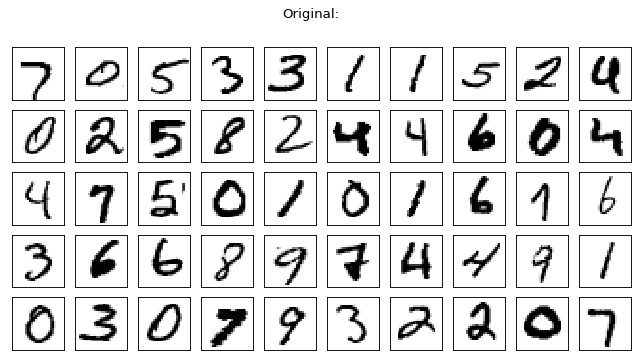

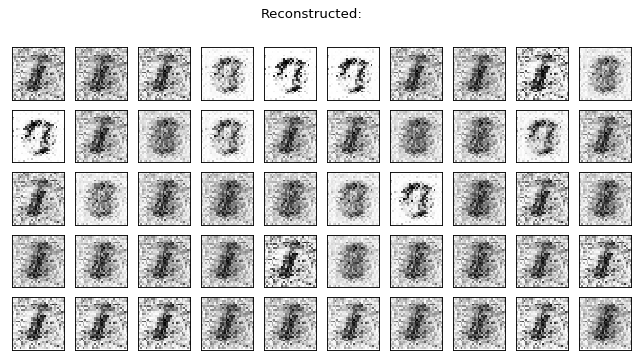

Test losses. G: 3.7015, D: 0.0337
Train Epoch: 11 [0/50000 (0%)]	Losses G: 5.1939, D: 0.1254
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 3.9192, D: 0.1502
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 4.5565, D: 0.1073
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.8650, D: 0.1019
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 4.9596, D: 0.0778
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.6739, D: 0.0732
Train Epoch: 13 [0/50000 (0%)]	Losses G: 5.5220, D: 0.0682
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 4.9479, D: 0.0799
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.3435, D: 0.1729
Train Epoch: 14 [0/50000 (0%)]	Losses G: 4.4319, D: 0.1873
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 5.0130, D: 0.0362
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.4439, D: 0.0845
Train Epoch: 15 [0/50000 (0%)]	Losses G: 5.3068, D: 0.0792
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 6.2888, D: 0.1210
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 5.1056, D: 0.0685
Train Epoch: 16 [0/50000 (

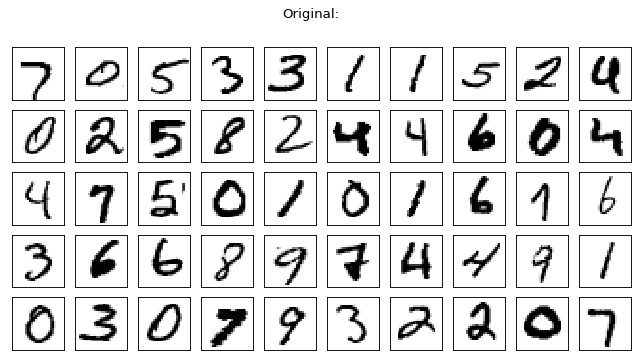

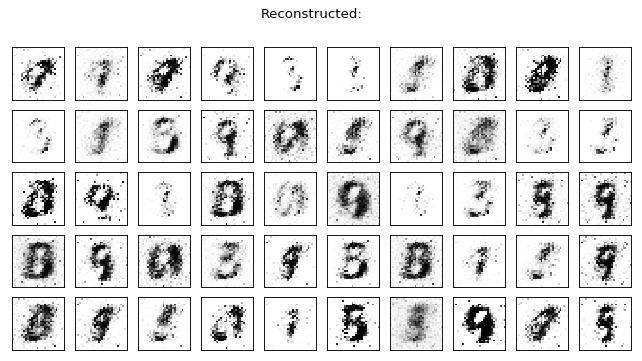

Test losses. G: 4.9045, D: 0.0355
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.9008, D: 0.1066
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 4.4917, D: 0.0757
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.6474, D: 0.0798
Train Epoch: 22 [0/50000 (0%)]	Losses G: 5.5792, D: 0.0816
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 5.3124, D: 0.0696
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 6.2868, D: 0.0494
Train Epoch: 23 [0/50000 (0%)]	Losses G: 6.2572, D: 0.0938
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 4.4207, D: 0.0734
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 6.6588, D: 0.0854
Train Epoch: 24 [0/50000 (0%)]	Losses G: 5.3702, D: 0.1390
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 5.5096, D: 0.0992
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 7.1008, D: 0.0706
Train Epoch: 25 [0/50000 (0%)]	Losses G: 6.2307, D: 0.0921
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 6.3133, D: 0.0643
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 5.9960, D: 0.0920
Train Epoch: 26 [0/50000 (

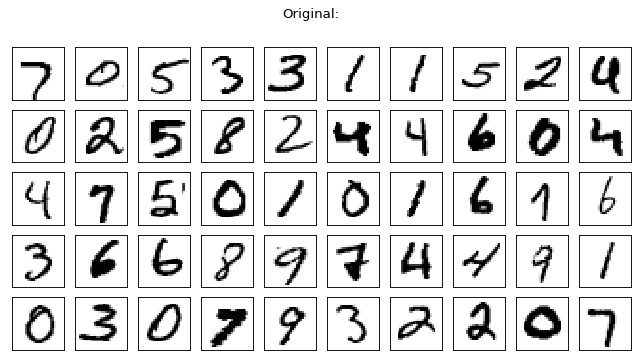

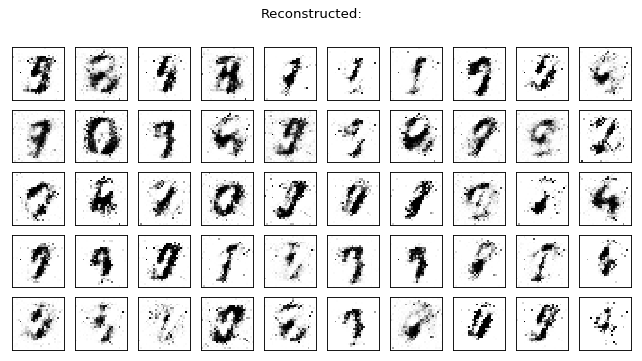

Test losses. G: 5.2367, D: 0.0471
Train Epoch: 31 [0/50000 (0%)]	Losses G: 5.4731, D: 0.0710
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 5.4175, D: 0.0880
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 5.0571, D: 0.1073
Train Epoch: 32 [0/50000 (0%)]	Losses G: 4.3048, D: 0.1043
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 5.1630, D: 0.1137
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 5.1012, D: 0.0721
Train Epoch: 33 [0/50000 (0%)]	Losses G: 5.3278, D: 0.1140
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 5.1364, D: 0.1419
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 4.7299, D: 0.0975
Train Epoch: 34 [0/50000 (0%)]	Losses G: 4.9756, D: 0.1227
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 5.3324, D: 0.0644
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 4.2013, D: 0.1438
Train Epoch: 35 [0/50000 (0%)]	Losses G: 4.6030, D: 0.1287
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 6.0559, D: 0.1230
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 5.4442, D: 0.1482
Train Epoch: 36 [0/50000 (

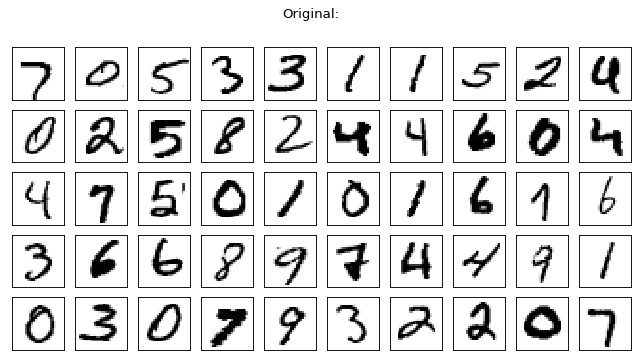

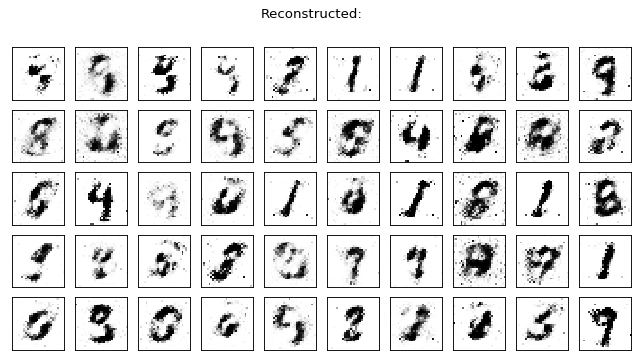

Test losses. G: 3.6876, D: 0.1095
Train Epoch: 41 [0/50000 (0%)]	Losses G: 3.6553, D: 0.2133
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 3.7797, D: 0.1820
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 3.3868, D: 0.1636
Train Epoch: 42 [0/50000 (0%)]	Losses G: 3.8198, D: 0.1555
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 3.3071, D: 0.1855
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 4.0010, D: 0.1866
Train Epoch: 43 [0/50000 (0%)]	Losses G: 3.9552, D: 0.1985
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 4.1149, D: 0.1975
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 3.9965, D: 0.1135
Train Epoch: 44 [0/50000 (0%)]	Losses G: 3.6760, D: 0.1329
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 3.2346, D: 0.1238
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 2.9084, D: 0.1241
Train Epoch: 45 [0/50000 (0%)]	Losses G: 3.2236, D: 0.1911
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 3.3575, D: 0.1737
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 3.1040, D: 0.2733
Train Epoch: 46 [0/50000 (

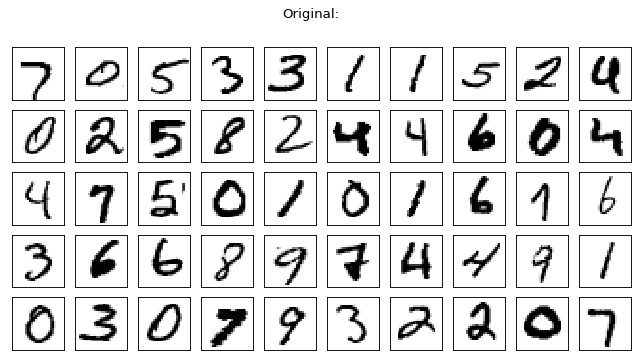

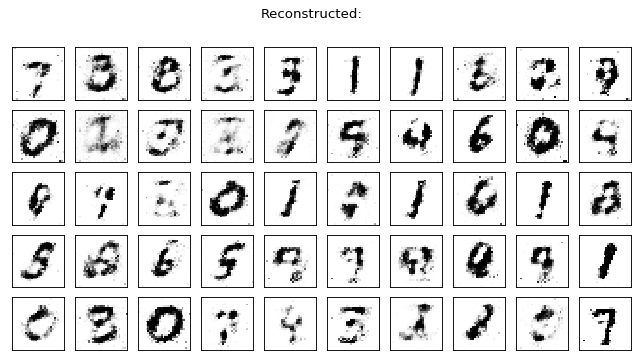

Test losses. G: 2.7268, D: 0.1848
Train Epoch: 51 [0/50000 (0%)]	Losses G: 2.9956, D: 0.2876
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 3.8015, D: 0.3064
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 2.9924, D: 0.3149
Train Epoch: 52 [0/50000 (0%)]	Losses G: 3.1675, D: 0.3709
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 2.7863, D: 0.2831
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 2.4940, D: 0.2718
Train Epoch: 53 [0/50000 (0%)]	Losses G: 2.3923, D: 0.2427
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 3.1847, D: 0.2968
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 2.4632, D: 0.2947
Train Epoch: 54 [0/50000 (0%)]	Losses G: 2.5007, D: 0.2775
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 3.1101, D: 0.2524
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 2.1857, D: 0.3332
Train Epoch: 55 [0/50000 (0%)]	Losses G: 2.4502, D: 0.3568
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 2.9240, D: 0.2783
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 3.0032, D: 0.2765
Train Epoch: 56 [0/50000 (

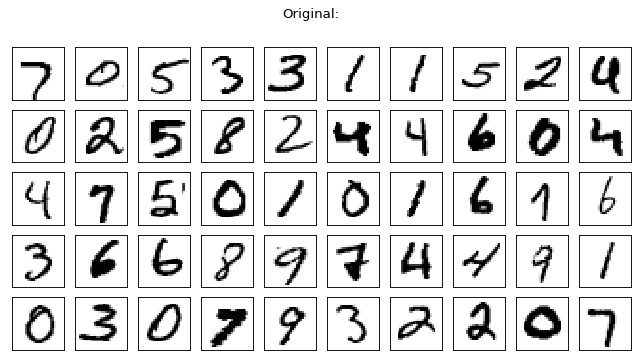

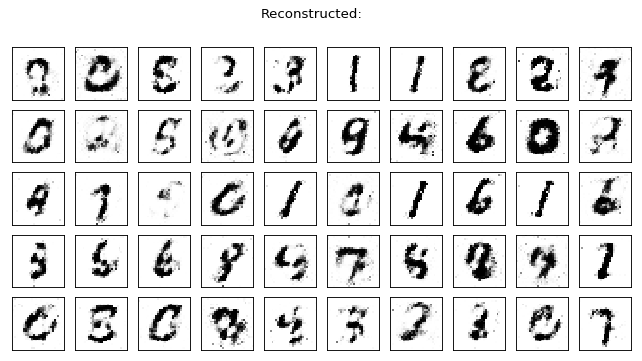

Test losses. G: 1.8853, D: 0.2359
Train Epoch: 61 [0/50000 (0%)]	Losses G: 2.7638, D: 0.3423
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 3.0340, D: 0.2501
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 2.9139, D: 0.3146
Train Epoch: 62 [0/50000 (0%)]	Losses G: 2.5794, D: 0.2853
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 2.4814, D: 0.3323
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 2.3422, D: 0.2918
Train Epoch: 63 [0/50000 (0%)]	Losses G: 2.4901, D: 0.3239
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 1.8501, D: 0.3029
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 2.6974, D: 0.2982
Train Epoch: 64 [0/50000 (0%)]	Losses G: 2.7639, D: 0.2743
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 3.1992, D: 0.3204
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 2.2557, D: 0.3301
Train Epoch: 65 [0/50000 (0%)]	Losses G: 2.1759, D: 0.2771
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 2.0973, D: 0.3250
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 2.0074, D: 0.3047
Train Epoch: 66 [0/50000 (

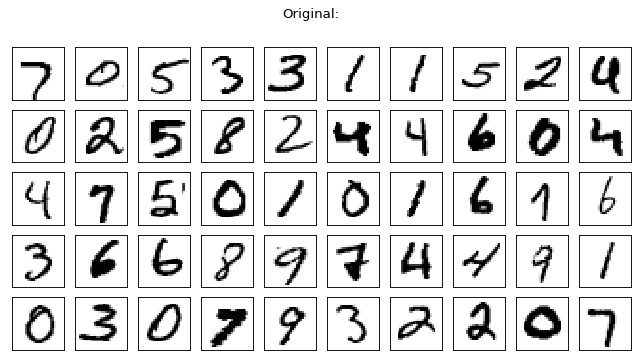

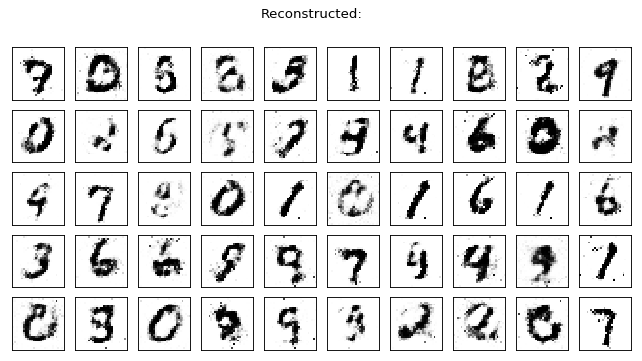

Test losses. G: 2.5270, D: 0.2021
Train Epoch: 71 [0/50000 (0%)]	Losses G: 2.5069, D: 0.2947
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 2.4025, D: 0.3026
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 2.4421, D: 0.3023
Train Epoch: 72 [0/50000 (0%)]	Losses G: 2.2357, D: 0.3430
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 2.4426, D: 0.2719
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 2.2201, D: 0.3335
Train Epoch: 73 [0/50000 (0%)]	Losses G: 2.2215, D: 0.3111
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 2.4271, D: 0.3645
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 2.1678, D: 0.2942
Train Epoch: 74 [0/50000 (0%)]	Losses G: 2.1955, D: 0.2922
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 2.1272, D: 0.3598
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 2.5277, D: 0.3735
Train Epoch: 75 [0/50000 (0%)]	Losses G: 2.2634, D: 0.3808
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 2.1075, D: 0.4535
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 1.7256, D: 0.4232
Train Epoch: 76 [0/50000 (

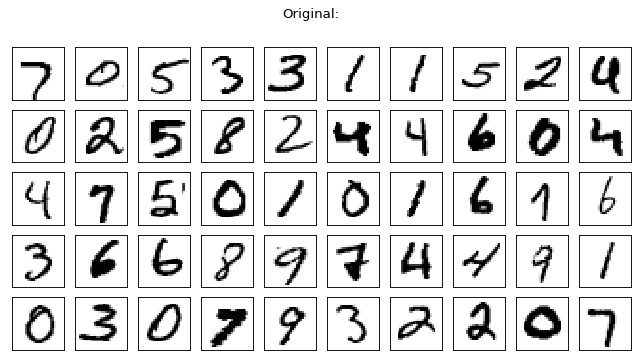

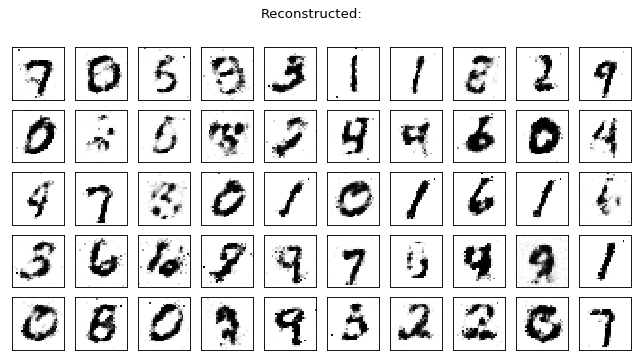

Test losses. G: 1.6248, D: 0.2644
Train Epoch: 81 [0/50000 (0%)]	Losses G: 1.8572, D: 0.3992
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.8898, D: 0.3911
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 1.7205, D: 0.3998
Train Epoch: 82 [0/50000 (0%)]	Losses G: 1.6860, D: 0.4435
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 2.0932, D: 0.3265
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 2.1294, D: 0.3343
Train Epoch: 83 [0/50000 (0%)]	Losses G: 2.1541, D: 0.3543
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 2.1421, D: 0.4026
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 2.0016, D: 0.4176
Train Epoch: 84 [0/50000 (0%)]	Losses G: 1.9602, D: 0.4373
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 2.0247, D: 0.3464
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 2.1825, D: 0.3189
Train Epoch: 85 [0/50000 (0%)]	Losses G: 2.2305, D: 0.3466
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 2.6571, D: 0.3182
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 2.2611, D: 0.3981
Train Epoch: 86 [0/50000 (

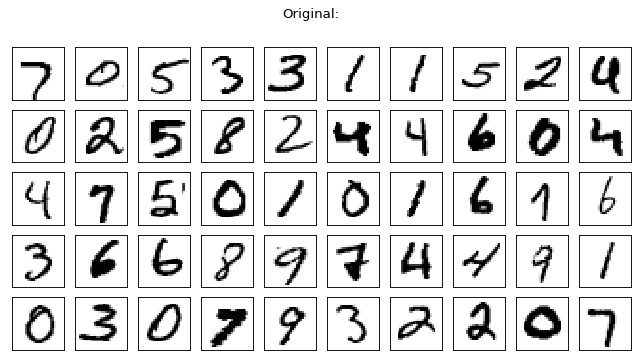

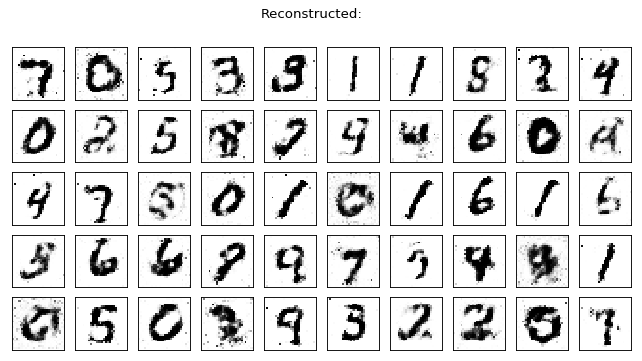

Test losses. G: 1.7051, D: 0.3733
Train Epoch: 91 [0/50000 (0%)]	Losses G: 1.6779, D: 0.4887
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 1.5557, D: 0.4906
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 1.4864, D: 0.5182
Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.5565, D: 0.5084
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 1.8830, D: 0.4650
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 1.7171, D: 0.4506
Train Epoch: 93 [0/50000 (0%)]	Losses G: 1.9162, D: 0.4380
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 1.8842, D: 0.4273
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 1.9637, D: 0.3650
Train Epoch: 94 [0/50000 (0%)]	Losses G: 1.6816, D: 0.3647
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 2.0578, D: 0.4483
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 1.4250, D: 0.4756
Train Epoch: 95 [0/50000 (0%)]	Losses G: 1.5414, D: 0.5023
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 1.8600, D: 0.3842
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 2.0196, D: 0.4016
Train Epoch: 96 [0/50000 (

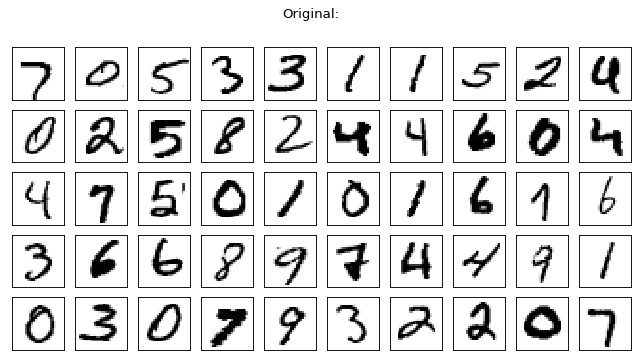

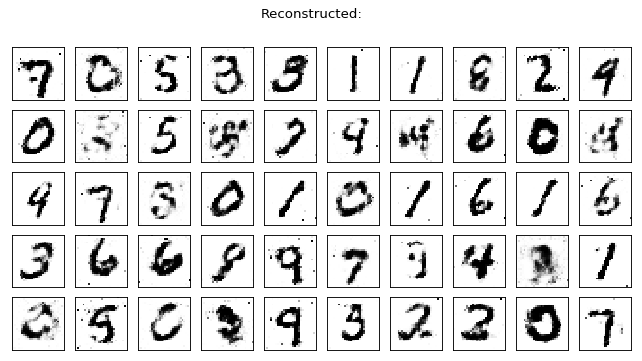

Test losses. G: 1.2221, D: 0.4244


In [16]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

# Adversarial Autoencoder

In [6]:
lr = 0.0005
latent_size = 10
batch_size = 50

batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [7]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

fixed_loader, _, _ = mnist(batch_size=50, valid=10000, transform=mnist_tanh)
fixed_data, labels = next(iter(fixed_loader))
fixed_z = torch.randn((50, latent_size))

In [11]:
Enc = FullyConnected([28*28, 512, 256, latent_size], 
                     activation_fn=nn.LeakyReLU(0.2), 
                     flatten=True)
Dec = FullyConnected([latent_size, 256, 512, 28*28], 
                     activation_fn=nn.LeakyReLU(0.2), 
                     last_fn=nn.Tanh())
Disc = FullyConnected([latent_size, 512, 256, 1], 
                      dropout=0.3, activation_fn=nn.LeakyReLU(0.2))

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [12]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [15]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train Disc
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        fake_pred = Disc(Enc(data))
        true_pred = Disc(torch.randn((batch_size, latent_size)))

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
                
        latent = Enc(data)
        reconstructed = Dec(latent).view(-1, 1, 28, 28)
        fake_pred = Disc(latent)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()

        if batch_idx % 500 == 0:
            print('Epoch {}, losses:\nReconstruction loss: {}\nDiscriminator loss: {}\n'.format(epoch, 
                                                                                                AE_loss, 
                                                                                                Disc_loss))

In [16]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    with torch.no_grad():
        for data, _ in loader:
            data = data.view(-1, 28 * 28)

            encoded = Enc(data)
            decoded = Dec(encoded)

            loss = F.mse_loss(decoded, data)

            true_pred = Disc(torch.randn(batch_size, latent_size))
            fake_pred = Disc(Enc(data))

            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
            disc_loss = 0.5 * (fake_loss + true_loss)

    loss /= test_size
    disc_loss /= test_size
    if epoch % 10 == 0:
        with torch.no_grad():
            ae_data = Dec(Enc(fixed_data.view(-1, 28 * 28))).data.numpy()
            fixed_gen = Dec(fixed_z).data.numpy()
            plot_mnist(fixed_data, (5, 10), 'Original:')
            plot_mnist(ae_data.reshape(-1, 1, 28, 28), (5, 10), 'Reconstructed:')
            plot_mnist(fixed_gen.reshape(-1, 1, 28, 28), (5, 10), 'Sampled')

    print('Test losses:\nReconstruction loss: {}\nDiscriminator loss: {}\n'.format(loss, disc_loss))

Epoch 1, losses:
Reconstruction loss: 0.9305492639541626
Discriminator loss: 0.6837517023086548

Epoch 1, losses:
Reconstruction loss: 0.2561452090740204
Discriminator loss: 0.8335987329483032

Test losses:
Reconstruction loss: 0.0010959370993077755
Discriminator loss: 0.003984220791608095

Epoch 2, losses:
Reconstruction loss: 0.24159835278987885
Discriminator loss: 0.8099693059921265

Epoch 2, losses:
Reconstruction loss: 0.20768971741199493
Discriminator loss: 0.7975929975509644

Test losses:
Reconstruction loss: 0.0009624678641557693
Discriminator loss: 0.003492816584184766

Epoch 3, losses:
Reconstruction loss: 0.20965316891670227
Discriminator loss: 0.6939313411712646

Epoch 3, losses:
Reconstruction loss: 0.17628072202205658
Discriminator loss: 0.7097734808921814

Test losses:
Reconstruction loss: 0.0007619286188855767
Discriminator loss: 0.0036053869407624006

Epoch 4, losses:
Reconstruction loss: 0.1451670229434967
Discriminator loss: 0.7204766273498535

Epoch 4, losses:
Recon

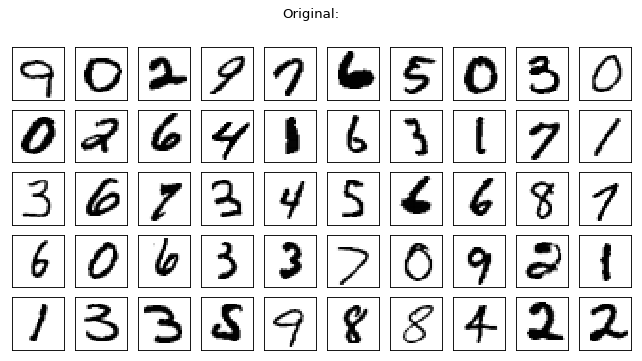

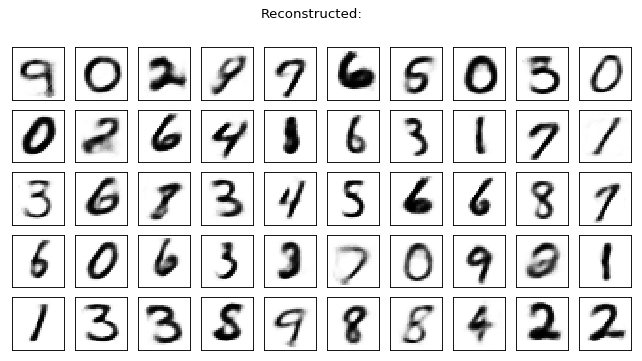

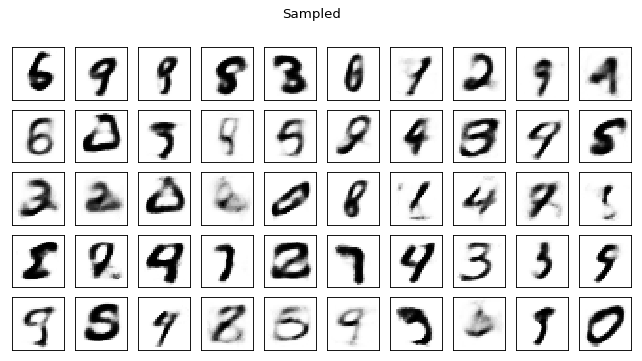

Test losses:
Reconstruction loss: 0.00037343910662457347
Discriminator loss: 0.0034598708152770996

Epoch 11, losses:
Reconstruction loss: 0.0682004913687706
Discriminator loss: 0.6919463872909546

Epoch 11, losses:
Reconstruction loss: 0.0694456622004509
Discriminator loss: 0.6910470724105835

Test losses:
Reconstruction loss: 0.0003853135567624122
Discriminator loss: 0.0034600261133164167

Epoch 12, losses:
Reconstruction loss: 0.06643656641244888
Discriminator loss: 0.6932828426361084

Epoch 12, losses:
Reconstruction loss: 0.0700429156422615
Discriminator loss: 0.6968947649002075

Test losses:
Reconstruction loss: 0.0003015394904650748
Discriminator loss: 0.00345293409191072

Epoch 13, losses:
Reconstruction loss: 0.0717027336359024
Discriminator loss: 0.696467399597168

Epoch 13, losses:
Reconstruction loss: 0.07155538350343704
Discriminator loss: 0.6962682604789734

Test losses:
Reconstruction loss: 0.0003371390630491078
Discriminator loss: 0.0034915944561362267

Epoch 14, losses

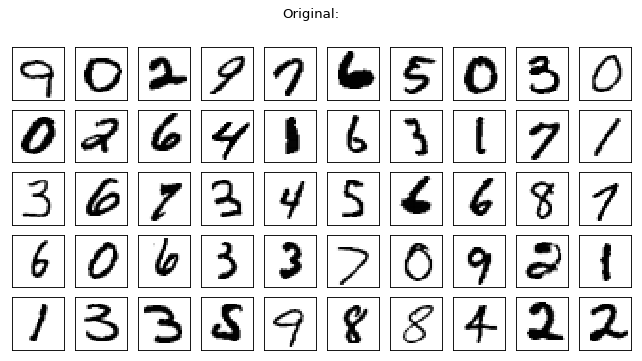

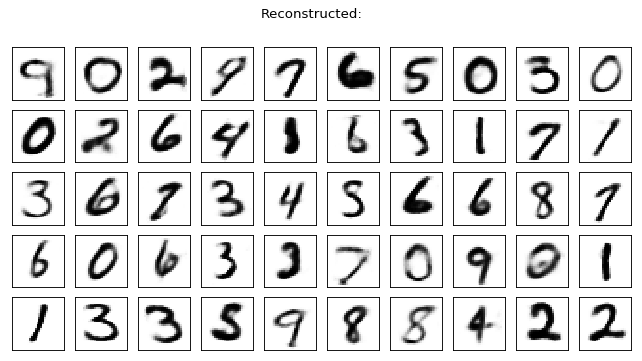

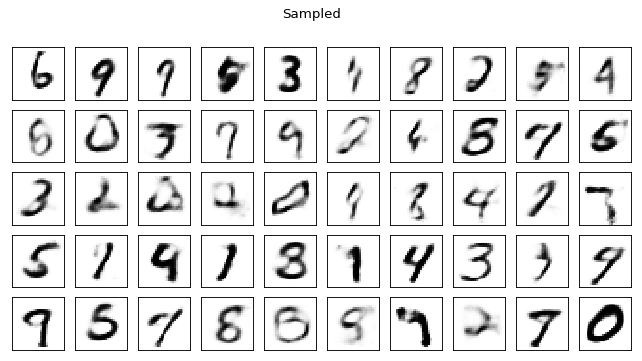

Test losses:
Reconstruction loss: 0.00033391561009921134
Discriminator loss: 0.003476997371762991

Epoch 21, losses:
Reconstruction loss: 0.06213127821683884
Discriminator loss: 0.697040855884552

Epoch 21, losses:
Reconstruction loss: 0.05407235398888588
Discriminator loss: 0.6925081610679626

Test losses:
Reconstruction loss: 0.00033926681498996913
Discriminator loss: 0.00349975167773664

Epoch 22, losses:
Reconstruction loss: 0.06591138988733292
Discriminator loss: 0.7003500461578369

Epoch 22, losses:
Reconstruction loss: 0.060760993510484695
Discriminator loss: 0.6957703828811646

Test losses:
Reconstruction loss: 0.0003093105333391577
Discriminator loss: 0.003475622506812215

Epoch 23, losses:
Reconstruction loss: 0.04672849550843239
Discriminator loss: 0.6961132287979126

Epoch 23, losses:
Reconstruction loss: 0.06196872889995575
Discriminator loss: 0.6930569410324097

Test losses:
Reconstruction loss: 0.00031838600989431143
Discriminator loss: 0.0034613357856869698

Epoch 24, l

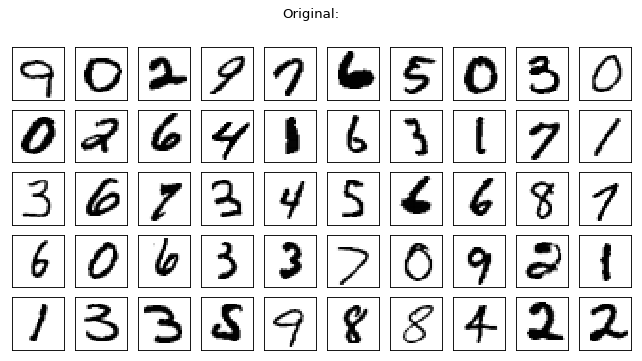

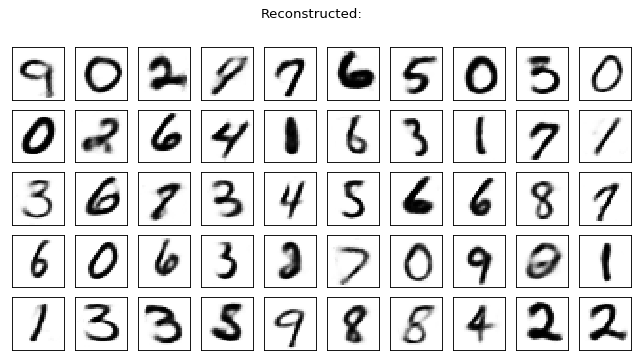

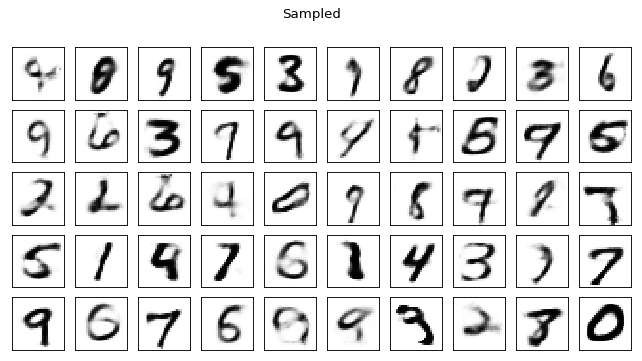

Test losses:
Reconstruction loss: 0.0002537238469813019
Discriminator loss: 0.0034591825678944588



In [17]:
for epoch in range(1, 31):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch)